Random tree forest

In [20]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

In [ ]:
path = '../data/paris_dataset_final_ready.csv.gz'
data_path = Path(path)
if not data_path.exists():
    raise FileNotFoundError(f"Dataset not found: {data_path}")
df = pd.read_csv(data_path, compression='gzip')
print(df.columns.tolist())

['accommodates', 'bedrooms', 'beds', 'minimum_nights_avg_ntm', 'number_of_reviews', 'price_clean', 'dist_to_center', 'bathrooms_qty', 'has_ac', 'has_elevator', 'has_dishwasher', 'has_parking', 'has_balcony', 'has_washing_machine', 'standing_thermal', 'score_chef_kitchen', 'score_coffee', 'score_wellness', 'score_work', 'score_view', 'score_secure', 'neigh_popularity', 'pg_entire_unit', 'pg_hotel', 'pg_private_room', 'rt_Entire home/apt', 'rt_Private room', 'rt_Shared room', 'city_label', 'target_class']


Feature/target split

In [ ]:
y = df['target_class']
X = df.drop(columns=['target_class', 'price_clean', 'city_label'])
# drop the raw price and city label — not useful here

print(f"\nFeatures (X) : {X.shape[1]} columns")
print(f"Target (y) : {len(y)} values")
print(f"\nClass distribution:")
print(y.value_counts().sort_index())


Features (X) : 27 colonnes
Target (y) : 73111 valeurs

Distribution des classes :
target_class
0    19114
1    17449
2    18299
3    18249
Name: count, dtype: int64


Train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=123
)   # stratify to preserve class distribution in both train and test sets

Grid search to find the best hyperparameters using cross-validation

In [ ]:
# hyperparameters to explore
param_grid = {
    # sqrt(p) is the standard choice, log2 is more conservative
    'max_features': ['sqrt', 'log2'], 

    # more trees reduces variance, but gains plateau at some point
    'n_estimators': [100, 300], 

    # deeper trees risk memorising the training data
    'max_depth': [10, 15, 20, 30],

    # minimum samples per leaf, higher values smooth out variance
    'min_samples_leaf': [2, 5, 10]
}


In [ ]:
def run_custom_grid_search(X, y, scoring_metric='accuracy'):
    print(f"\n Running Grid Search (metric: {scoring_metric})...")
    
    rf = RandomForestClassifier(random_state=123, n_jobs=-1)
    
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,                  # 5-Fold Cross Validation
        scoring=scoring_metric,
        return_train_score=True, # to check for overfitting
        n_jobs=-1
    )
    
    grid_search.fit(X, y)
    
    results = pd.DataFrame(grid_search.cv_results_)
    
    cols_interest = [
        'param_max_depth', 'param_max_features', 'param_min_samples_leaf', 'param_n_estimators',
        'mean_test_score', 'std_test_score',  # Validation performance (Variance)
        'mean_train_score'                    # Training performance (Bias)
    ]
    summary = results[cols_interest].copy()
    
    # Rename for readability
    summary.rename(columns={
        'mean_test_score': 'Mean_CV_Score',
        'std_test_score': 'CV_Std (Variance)',
        'mean_train_score': 'Train_Score (Overfit?)'
    }, inplace=True)
    
    # Sort by best validation score
    summary = summary.sort_values(by='Mean_CV_Score', ascending=False)
    
    return grid_search.best_estimator_, summary

Grid search over accuracy and F1-macro

In [ ]:
# change the flag to True if you want to rerun the 
# takes between 8 and 20 mins
RUN_GRID_SEARCH = False
if RUN_GRID_SEARCH:    
# grid search on accuracy
    best_model_acc, res_acc = run_custom_grid_search(X_train, y_train, scoring_metric='accuracy')

    print("\n Top 5 configurations (accuracy):")
    # check the top 5 to manually pick the best trade-off
    print(res_acc.head(5).to_string(index=False))



 Lancement de la Grid Search (Métrique : accuracy)...
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/Delphine/Library/CloudStorage/OneDrive-Personnel/Visual_Studio_Code/Projet_ML_legend/ML_Airbnb_domain_generalisation/data_science_env/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/Delphine/Library/CloudStorage/OneDrive-Personnel/Visual_Studio_Code/Projet_ML_legend/ML_Airbnb_domain_generalisation/data_science_env/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/Delphine/Library/CloudStorage/OneDrive-Personnel/Visual_Studio_Code/Projet_ML_legend/ML_Airbnb_domain_generalisation/data_science_env/lib/p


 top 5 configurations (accuracy) :
 param_max_depth param_max_features  param_min_samples_leaf  param_n_estimators  Score_Moyen_CV  Ecart_Type_CV (Variance)  Score_Train (Overfit?)
              20               log2                       2                 300        0.560081                  0.006387                0.846028
              20               sqrt                       2                 300        0.559910                  0.005100                0.861848
              20               sqrt                       5                 300        0.559841                  0.005041                0.732539
              20               log2                       5                 300        0.559140                  0.006273                0.716938
              30               sqrt                       5                 300        0.559123                  0.004630                0.753522


5 folds for the CV — with 73k rows that's roughly 14k samples per fold, solid enough for reliable estimates without running for hours.

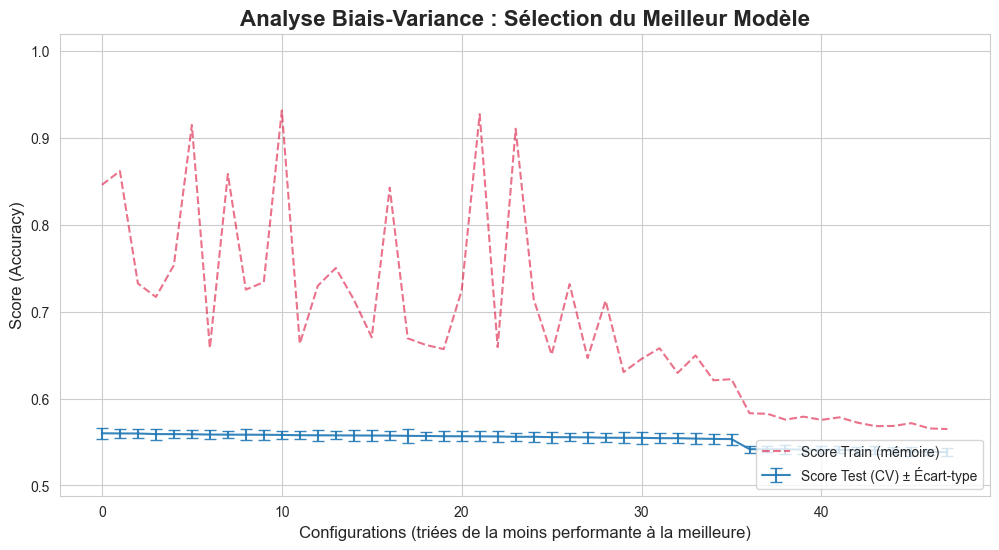

In [ ]:
# Re-run this if you relaunch the grid search to get up-to-date results

plt.figure(figsize=(12, 6))

x_axis = range(len(res_acc))

# mean validation score with error bars 
plt.errorbar(
    x=x_axis,
    y=res_acc['Mean_CV_Score'],
    yerr=res_acc['CV_Std (Variance)'],
    elinewidth=1.5,
    capsize=4,
    alpha=0.9,
    label='Test Score (CV) ± Std'
)

# training score to spot overfitting
plt.plot(
    x_axis,
    res_acc['Train_Score (Overfit?)'],
    color='crimson',
    linestyle='--',
    alpha=0.6,
    label='Train Score (memorisation)'
)

plt.title('Bias-Variance Analysis: Model Selection', fontsize=16, fontweight='bold')
plt.xlabel('Configurations (sorted from worst to best)', fontsize=12)
plt.ylabel('Score (Accuracy)', fontsize=12)
plt.legend(loc='lower right', frameon=True)

min_y = res_acc['Mean_CV_Score'].min() - 0.05
plt.ylim(min_y, 1.02)

plt.show()


### Bias-variance trade-off

On the left of the chart, configs with very deep trees memorise the training set (red score near 90%) but stall around 0.56 in validation — the gap speaks for itself.

Towards the right, the training score comes down (~73%) while the test score stays stable. that's the zone we care about: less memorisation, better generalisation.

Also running on F1-macro to check if it changes anything — in theory it shouldn't, the classes are balanced by construction. No need to re-run this!

In [ ]:
# change the flag to True if you want to rerun the 
# takes between 8 and 20 mins
RUN_GRID_SEARCH = False
if RUN_GRID_SEARCH:    
    # TEST ON F1-MACRO
    best_model_f1, res_f1 = run_custom_grid_search(X_train, y_train, scoring_metric='f1_macro')

    print("\n TOP 5 CONFIGURATIONS (F1-MACRO):")
    print(res_f1.head(5).to_string(index=False))


 Lancement de la Grid Search (Métrique : f1_macro)...
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/Delphine/Library/CloudStorage/OneDrive-Personnel/Visual_Studio_Code/Projet_ML_legend/ML_Airbnb_domain_generalisation/data_science_env/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/Delphine/Library/CloudStorage/OneDrive-Personnel/Visual_Studio_Code/Projet_ML_legend/ML_Airbnb_domain_generalisation/data_science_env/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/Delphine/Library/CloudStorage/OneDrive-Personnel/Visual_Studio_Code/Projet_ML_legend/ML_Airbnb_domain_generalisation/data_science_env/lib/p


 TOP 5 CONFIGURATIONS (F1-MACRO) :
 param_max_depth param_max_features  param_min_samples_leaf  param_n_estimators  Score_Moyen_CV  Ecart_Type_CV (Variance)  Score_Train (Overfit?)
              20               sqrt                       2                 300        0.550632                  0.005294                0.861492
              20               log2                       2                 300        0.550313                  0.006540                0.845385
              20               sqrt                       5                 300        0.549906                  0.005348                0.728854
              30               log2                       2                 300        0.549513                  0.004850                0.915007
              30               sqrt                       2                 300        0.549289                  0.004960                0.931642


The best model by F1-macro matches the 2nd-best by accuracy, but with noticeably lower variance. That's the one we keep.

Training the optimal model

In [ ]:
# Hardcoded optimal parameters so we don't have to rerun the grid search
opti_max_depth = 20
opti_param_max_features = 'sqrt'
opti_param_min_samples_leaf = 5
opti_param_n_estimators = 300

In [ ]:
rf_opti = RandomForestClassifier(
    n_estimators=opti_param_n_estimators,
    max_depth=opti_max_depth,
    min_samples_leaf=opti_param_min_samples_leaf,
    max_features=opti_param_max_features,
    random_state=123,
    n_jobs=-2       # leave one cpu core free
)

In [13]:
rf_opti.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

Simplified example of a prediction on a test listing

Results of the optimal model on the test set

In [ ]:
y_pred = rf_opti.predict(X_test)
# Scores
acc = accuracy_score(y_test, y_pred)
f1_macro = classification_report(y_test, y_pred, output_dict=True)['macro avg']['f1-score']
print(f"\n FINAL ACCURACY: {acc:.2%}")
print(f" F1-MACRO: {f1_macro:.2%}")


 PRÉCISION FINALE (Accuracy) : 56.73%
 F1-MACRO : 55.75%


In [ ]:
target_names = ['Budget (0)', 'Standard (1)', 'Premium (2)', 'Luxury (3)']
print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred, target_names=target_names))


--- RAPPORT DE CLASSIFICATION ---
              precision    recall  f1-score   support

     Éco (0)       0.61      0.73      0.66      3823
Standard (1)       0.44      0.39      0.42      3490
 Premium (2)       0.50      0.43      0.46      3660
    Luxe (3)       0.67      0.70      0.69      3650

    accuracy                           0.57     14623
   macro avg       0.56      0.56      0.56     14623
weighted avg       0.56      0.57      0.56     14623



The OOB score is the forest's internal estimate of its own performance: each tree is evaluated on the samples it never saw during training. If it's close to the test score, that's a good sign

In [ ]:
print("\n=== OOB validation (out-of-bag) ===")

# same params as rf_opti, just with oob_score=True added
rf_oob = RandomForestClassifier(
    n_estimators=opti_param_n_estimators,
    max_depth=opti_max_depth,
    min_samples_leaf=opti_param_min_samples_leaf,
    max_features=opti_param_max_features,
    oob_score=True,
    random_state=123
)

rf_oob.fit(X_train, y_train)

oob_acc = rf_oob.oob_score_
test_acc = accuracy_score(y_test, rf_oob.predict(X_test))

print(f" OOB (internal estimate) : {oob_acc:.4f}")
print(f" Test score (real validation) : {test_acc:.4f}")

if abs(oob_acc - test_acc) < 0.02:
    print("Both scores are very close — the model generalises well.")



=== validation OOB (out-of-bag) ===
 OOB (estimation interne) : 0.5596
 score test (validation réelle) : 0.5673
les deux scores sont très proches, le modèle généralise bien.


OOB Validation

The OOB score (0.5599) is very close to the test set accuracy (0.57). This confirms the results don't depend on a lucky train/test split — the model is stable.

Confusion Matrix

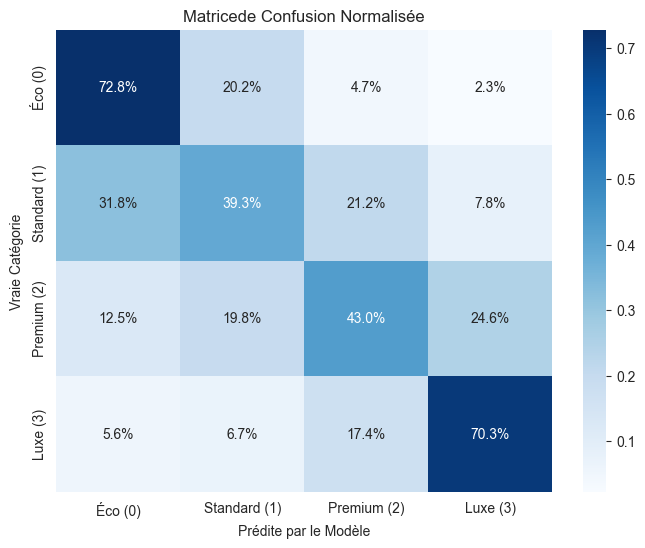

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)

# Normalise to get percentages
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cmn, annot=True, fmt='.1%', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.ylabel('True Category')
plt.xlabel('Predicted by the Model')
plt.title('Normalised Confusion Matrix')
plt.show()

### Reading the confusion matrix

The model does well at the extremes: **Budget** at 72.9% and **Luxury** at 70.1%. These two categories have fairly distinct profiles, so the model picks them up without too much trouble.

Where it struggles is between **Standard** and **Premium** (around 40% each). The difference between these classes often comes down to visual cues — decor, natural light, overall feel — which tabular data doesn't really capture.

Misclassifications stay reasonable: the model almost always errs by at most one class. Severe errors (Budget confused with Luxury or vice versa) account for less than 6% of cases.

INTERPRETATION (FEATURE IMPORTANCE)

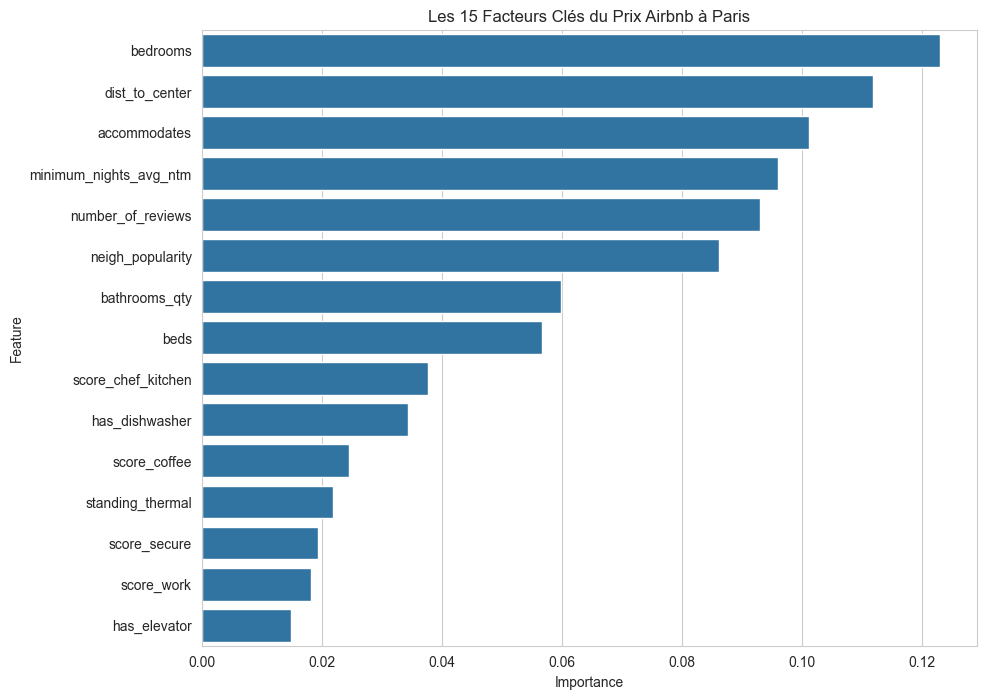

In [ ]:
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_opti.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importances.head(15))
plt.title('Top 15 Factors Driving Airbnb Prices in Paris')
plt.show()

Feature importance measures each variable's cumulative contribution to reducing Gini impurity across all trees. The more effectively a variable separates classes, the higher its score.

### What drives price in Paris

Unsurprisingly, **listing size** dominates: bedrooms, accommodates and beds are all at the top. **dist_to_center** comes right after — the Parisian real estate logic is well captured.

This chart ranks variables by their impact on the model's decisions:

1.  **Apartment structure:** **bedrooms** is the top predictor, closely followed by **accommodates** (capacity) and **beds**. Size is the main driver of price by a wide margin.
2.  **Location:** **dist_to_center** (distance to Notre-Dame) is the second most influential feature, confirming the classic Parisian real estate pattern.
3.  **Host profile:** **minimum_nights** and **number_of_reviews** rank surprisingly high. This suggests that professional hosts — who require longer stays and accumulate reviews — have pricing strategies that differ meaningfully from occasional renters.
4.  **Amenities:** Multiple bathrooms (**bathrooms_qty**) and a well-equipped kitchen (**score_chef_kitchen**) are the most discriminating comfort indicators.

### Performance summary

57% accuracy on 4 balanced classes — given that random guessing would give 25%, the model is clearly learning something meaningful.

The F1-macro at 0.56 confirms we're not gaming the metric by favouring one class: performance is fairly consistent across all four. The extreme classes (Budget and Luxury) are predicted more reliably; the middle ones are harder to tell apart without visual data.

Overall the model is usable for filtering price ranges, even if you shouldn't expect pinpoint precision between Standard and Premium.